<a href="https://colab.research.google.com/github/pauljhp/Auto_Stockselection/blob/main/All_US_Companies_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy, math
import pandas as pd
import numpy as np
import requests
from collections import Counter
from bs4 import BeautifulSoup as bs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# connect to google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **0. Load in Data**

In [103]:
pivot_data = pd.read_csv("/content/drive/MyDrive/stockClassification/sector_specific/us_all_co_pivot_data_allfieldsadded.csv",
                         header=[0,1],
                         index_col=list(range(15)))
pivot_data.columns = pd.MultiIndex.from_tuples(list(tuple(
    zip(pivot_data.columns.get_level_values(0),
        pivot_data.columns.get_level_values(1).astype(float)
        )
    )
),
    names=('field', 'fyear')
              )

## 0.1 Generate training dataset

In [104]:
# let's define a function that returns the X, y datasets given a certain year
def getDataSet(year, pivot_data=pivot_data, target_field='revt', target_criteria='cagr', 
               forward_period=5, missing_data_tolerance=0.5, return_X_y=True, 
               return_y_only=False) -> (pd.DataFrame, pd.Series):
    """returns X (pd.DataFrame) and y (pd.Series)
    Parameters
    --------
    - year: year selected
    - pivot_data: data source
    - target_field: the field which will form y, the target variable.
    - target_criteria: takes 'cagr' or 'chg'. 
        > 'cagr' will calculate the cagr between the period selected and the 
          forward period;
        > 'chg' will simply calculate the change in percentage. 
        > use 'cagr' for absolute variables like revt, mkvalt, and use 'chg' for 
          ratios like ebitda_margin
    - forward_period: the look-ahead periods for generating y 
    - missing_data_tolerance: if an observation has > threshold % of missing data,
        observation will be dropped
    - return_X_y: if True, returns tuple of (X, y), else return X_y in the same
        dataframe
    """
    data = pivot_data.copy()
    # data.index
    values = ['act', 'at', 'ebitda', 'seq', 'revt', 'mkvalt']
    ratios = [
            'ebit_margin', 'ebitda_margin', 'gp_margin', 'ni_margin', 'fcf_margin',
            'nopat_margin', 'ocf_margin', 'rd_exp_ratio', 'sga_ratio', 'tax_rate', 'roe',
            ] 
    vs_gind = ['market_share'] + [f"{rat}_vs_gind" for rat in ratios] + [f"{rat}_vs_gind_std" for rat in ratios]
    ratios += vs_gind
    flds = values + ratios
    if forward_period + year > 2020:
        raise ValueError("forwrard_period in the future!")
    
    if not return_y_only:
        # make X
        data_X = data.loc[:, (data.columns.get_level_values(1) <= year) & (data.columns.get_level_values(0).isin(flds))]
        data_X = data_X.reset_index(["ggroup", "gind", "sic", "y_cross_5", "y_cross_10", 
                            "y_cross_50", "y_cross_100", "y_cross_500", "y_cross_1000", 
                            "y_cross_5000", "y0_reporting"])
        X = pd.DataFrame(dtype=object, index=data_X.index)

        # add growth trajectory
        threshold = [5, 10, 50, 100, 500, 1000, 5000]
        for a, b in zip(threshold[:-1], threshold[1:]):
            y_since_ = (data_X.loc[:, f"y_cross_{b}"] - data_X.loc[:, f"y_cross_{a}"]).replace(0, np.nan)
            X.loc[:, f"years_from_{a}_to_{b}" ] = y_since_
            # del y_since_
        X.loc[:, "years_since_y0"] = year - data_X.loc[:, "y0_reporting"].values
        cagr_periods = [1, 3, 5, 10, 20]

        for fld in values:
            if fld == 'mkvalt': #mkval only after 1998, cashflow data only after 1987
                start_periods = [year - p for p in cagr_periods if year - p >= 1998]
            else:
                start_periods = [year - p for p in cagr_periods if year - p >= 1950]
            for p in start_periods:
                X.loc[:, f"{fld}_{year - p}yr_cagr"] = (data_X.loc[:, (fld, year)] / data_X.loc[:, (fld, p)].values) ** (1 / (year - p)) - 1

        for fld in ratios:
            if fld in ['fcf_margin', 'ocf_margin', 'fcf_margin_vs_gind', 
                    'ocf_margin_vs_gind', 'fcf_margin_vs_gind_std', 
                    'ocf_margin_vs_gind_std']: #mkval only after 1998, cashflow data only after 1987
                start_periods = [year - p for p in cagr_periods if year - p >= 1987]
            else:
                start_periods = [year - p for p in cagr_periods if year - p >= 1950]
            for p in start_periods:
                X.loc[:, f"{fld}_t{year - p}yr_avg"] = data_X.loc[:, (fld, np.arange(p, year + 1))].replace(float("inf"), np.nan).replace(float("-inf"), np.nan).mean(axis="columns")
                X.loc[:, f"{fld}_t{year - p}yr_std"] = data_X.loc[:, (fld, np.arange(p, year + 1))].replace(float("inf"), np.nan).replace(float("-inf"), np.nan).std(axis="columns")
                X.loc[:, f"{fld}_t{year - p}yr_chg"] = data_X[fld][year] - data_X[fld][p]

        X.loc[:, "ggroup"] = data_X.ggroup.apply(lambda x: int(x))
        X.loc[:, "gind"] = data_X.gind.apply(lambda x: int(x))
        X.loc[:, "sic"] = data_X.sic.apply(lambda x: int(x))
        mkcap_bins = rev_bins = seq_bins = [10**i for i in np.arange(0, 10, 0.5)]
        bin_labels = [f"{a // 10 ** math.floor(math.log(a, 10)):.0f}*10e{math.log(a, 10):.0f}<x<={b // 10 ** math.floor(math.log(b, 10)):.0f}*10e{math.log(b, 10):.0f}" for a, b in zip(rev_bins[:-1], rev_bins[1:])]
        for fld in values:
            if not (fld == 'mkvalt' and year < 1998): #mkval only after 1998, cashflow data only after 1987
                X.loc[:, f"{fld}_bins"] = pd.cut(data_X[fld][year], bins=rev_bins, labels=bin_labels)
            else:
                X.loc[:, f"{fld}_bins"] = np.nan

    # make y
    data_y = data.loc[:, (data.columns.get_level_values(1) <= year + forward_period) & (data.columns.get_level_values(0) == target_field)]
    if target_criteria == 'cagr':
        y = (data_y[target_field][year + forward_period] / data_y[target_field][year].values) ** (1 / forward_period) - 1
        y.name = 'target'
        y.index = pd.MultiIndex.from_tuples([(t, year) for t in y.index.get_level_values('tic')], names=('tic', 'year'))
    elif target_criteria == 'change':
        y = (data_y[target_field][year + forward_period] - data_y[target_field][year].values)
        y.name = 'target'
        y.index = pd.MultiIndex.from_tuples([(t, year) for t in y.index.get_level_values('tic')], names=('tic', 'year'))
    else:
        raise ValueError("target_criteria can only be 'cagr' or 'change'!")
    
    if not return_y_only:
        X_y = X.merge(y, on='tic', how='outer')
        X_y.index = pd.MultiIndex.from_tuples([(t, year) for t in X_y.index], names=('tic', 'year'))
        X_y = X_y[~X_y.target.isna()]
        X_y = X_y.loc[X_y.isna().sum(axis='columns') / len(X_y.columns) < missing_data_tolerance] # filter away observations with > 50% missing fields
        X = X_y.drop("target", axis="columns")
        y = X_y.target 
        if return_X_y:
            return X, y
        else:
            return X_y
    else:
        return y

In [ ]:
######################################################
####### skip this if dataset already generated #######
######################################################
# get datasets from 1980 to 2014
datasets = []
start_year, end_year  = 1980, 2015
for year in range(start_year, end_year):
    X_y = getDataSet(year, return_X_y=False)
    datasets.append(X_y)
X_y = pd.concat(datasets)
del datasets
X_revt, y_revt = X_y.drop("target", axis="columns"), X_y.target

# save this dataset
X_y.to_csv(f"/content/drive/MyDrive/stockClassification/sector_specific/all_us_co_{start_year}to{end_year - 1}_training.csv")
# del X_y

In [ ]:
######################################################
####### skip this if dataset already generated #######
######################################################
# get y_ebitda_margin, y_gp_margin, y_ni_margin from 1980 to 2014
flds = ['ebitda_margin', 'gp_margin', 'ni_margin']
datasets = {fld: [] for fld in flds}
start_year, end_year  = 1980, 2015
for year in range(start_year, end_year):
    for fld in flds:
        datasets[fld].append(getDataSet(year=year, return_X_y=False, target_field=fld, 
                                             target_criteria='change', forward_period=5, 
                                             missing_data_tolerance=0.5, return_y_only=False)
        )
for fld, ls in datasets.items():
    df = pd.concat(ls)
    df.to_csv(f"/content/drive/MyDrive/stockClassification/sector_specific/all_us_co_{start_year}to{end_year - 1}_training_{fld}.csv")

In [8]:
# load in X_y from saved - revt cagr change
start_year, end_year = 1980, 2015
flds = ['revt', 
        'ebitda_margin', 
        # 'gp_margin', 
        # 'ni_margin'
        ]
filter_out = ['1*10e0<x<=3*10e0','3*10e0<x<=1*10e1',
              '1*10e1<x<=3*10e1', '3*10e1<x<=1*10e2', 
            #   '1*10e2<x<=3*10e2'
              ] # only 100m+ revenue companies
X_ys = {fld: {} for fld in flds}
for fld in flds:
    if fld == 'revt':
        X_ys[fld]['X_y'] = pd.read_csv(f"/content/drive/MyDrive/stockClassification/sector_specific/all_us_co_{start_year}to{end_year - 1}_training.csv", 
                                header=0, index_col=[0, 1])
        X_ys[fld]['X'] = X_ys[fld]['X_y'].loc[~X_ys[fld]['X_y'].revt_bins.isin(filter_out)].replace(float("inf"), np.nan).replace(float("-inf"), np.nan).drop("target", axis="columns")
        X_ys[fld]['y'] = X_ys[fld]['X_y'].loc[~X_ys[fld]['X_y'].revt_bins.isin(filter_out)].replace(float("inf"), np.nan).replace(float("-inf"), np.nan).target
        del X_ys[fld]['X_y'] # del X_y for garbage collection
    else:
        # pass
        X_ys[fld]['X_y'] = pd.read_csv(f"/content/drive/MyDrive/stockClassification/sector_specific/all_us_co_{start_year}to{end_year - 1}_training_{fld}.csv", 
                                header=0, index_col=[0, 1])
        # if fld != 'ebitda_margin':
        #     X_ys[fld]['X_y'].loc[:, 'target'] = X_ys[fld]['X_y'].target + 1
        #     X_ys[fld]['X_y'].to_csv(f"/content/drive/MyDrive/stockClassification/sector_specific/all_us_co_{start_year}to{end_year - 1}_training_{fld}.csv")
        X_ys[fld]['X'] = X_ys[fld]['X_y'].loc[~X_ys[fld]['X_y'].revt_bins.isin(filter_out)].replace(float("inf"), np.nan).replace(float("-inf"), np.nan).drop("target", axis="columns")
        X_ys[fld]['y'] = X_ys[fld]['X_y'].loc[~X_ys[fld]['X_y'].revt_bins.isin(filter_out)].replace(float("inf"), np.nan).replace(float("-inf"), np.nan).target
        del X_ys[fld]['X_y'] 


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (462) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


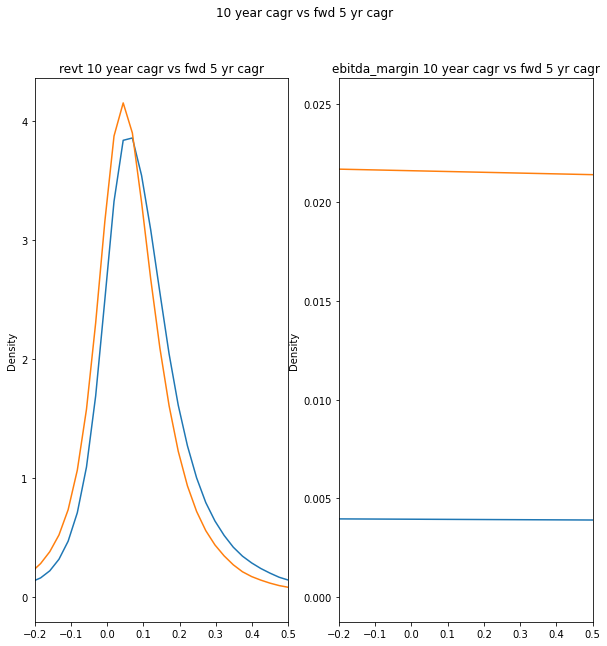

In [9]:
# visualize
f, axes = plt.subplots(len(flds) // 2 + len(flds) % 2, 2, figsize=(10, 10), sharex=True, sharey=False)
for i, (fld, d) in enumerate(X_ys.items()):
    ax = axes[i // 2, i % 2] if len(flds) > 2 else axes[i]
    loc = f"{fld}_5yr_cagr" if fld == 'revt' else f"{fld}_t5yr_chg"
    d['X'][loc].plot(kind='kde', xlim=(-0.2, 0.5), ax=ax, label="t5year")
    d['y'].plot(kind='kde', xlim=(-0.2, 0.5), ax=ax, label="f5yr")
    # ax[i].legend()
    ax.set(title=f"{fld} 10 year cagr vs fwd 5 yr cagr")
plt.suptitle("10 year cagr vs fwd 5 yr cagr")
plt.show()

del f, axes

In [11]:
# change y to change in cagr for revt only
for fld, d in X_ys.items():
    if fld == 'revt':
        hist_g = (d['X'].revt_1yr_cagr * 0.3 + d['X'].revt_3yr_cagr * 0.3
                    + d['X'].revt_5yr_cagr * 0.2 + d['X'].revt_10yr_cagr * 0.2)
        X_ys[fld]['y'] = pd.Series(d['y'].values - hist_g.values,
                    index=d['y'].index)

    # remove na in y for all 
    X_ys[fld]['X'], X_ys[fld]['y'] = X_ys[fld]['X'].loc[~X_ys[fld]['y'].isna()], X_ys[fld]['y'].loc[~X_ys[fld]['y'].isna()]

In [ ]:
corr_mt = X_y.corr()

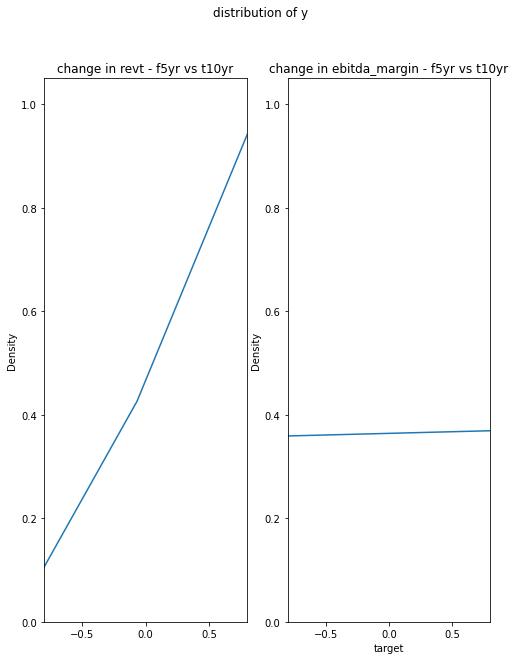

In [17]:
import seaborn as sns
f, axes = plt.subplots(len(flds) // 2 + len(flds) % 2, 2, figsize=(8, 10), sharex=True, sharey=False)
plt.suptitle("distribution of y")
for i, (fld, d) in enumerate(X_ys.items()):
    ax = axes[i // 2, i % 2] if len(flds) > 2 else axes[i]
    sns.kdeplot(d['y'], cumulative=True, ax=ax,
        )
    ax.set(title=f"change in {fld} - f5yr vs t10yr", 
           xlim=(-.8, .8))

# **1. Preprocessing**

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## 1.1 Removing inf & invalid values

In [19]:
X_ys['revt']['X'].describe()

,years_from_5_to_10,years_from_10_to_50,years_from_50_to_100,years_from_100_to_500,years_from_500_to_1000,years_from_1000_to_5000,years_since_y0,act_1yr_cagr,act_3yr_cagr,act_5yr_cagr,act_10yr_cagr,act_20yr_cagr,at_1yr_cagr,at_3yr_cagr,at_5yr_cagr,at_10yr_cagr,at_20yr_cagr,ebitda_1yr_cagr,ebitda_3yr_cagr,ebitda_5yr_cagr,ebitda_10yr_cagr,ebitda_20yr_cagr,seq_1yr_cagr,seq_3yr_cagr,seq_5yr_cagr,seq_10yr_cagr,seq_20yr_cagr,revt_1yr_cagr,revt_3yr_cagr,revt_5yr_cagr,revt_10yr_cagr,revt_20yr_cagr,ebit_margin_t1yr_avg,ebit_margin_t1yr_std,ebit_margin_t1yr_chg,ebit_margin_t3yr_avg,ebit_margin_t3yr_std,ebit_margin_t3yr_chg,ebit_margin_t5yr_avg,ebit_margin_t5yr_std,...,fcf_margin_t10yr_avg,fcf_margin_t10yr_std,fcf_margin_t10yr_chg,ocf_margin_t10yr_avg,ocf_margin_t10yr_std,ocf_margin_t10yr_chg,fcf_margin_vs_gind_t10yr_avg,fcf_margin_vs_gind_t10yr_std,fcf_margin_vs_gind_t10yr_chg,ocf_margin_vs_gind_t10yr_avg,ocf_margin_vs_gind_t10yr_std,ocf_margin_vs_gind_t10yr_chg,fcf_margin_vs_gind_std_t10yr_avg,fcf_margin_vs_gind_std_t10yr_std,fcf_margin_vs_gind_std_t10yr_chg,ocf_margin_vs_gind_std_t10yr_avg,ocf_margin_vs_gind_std_t10yr_std,ocf_margin_vs_gind_std_t10yr_chg,mkvalt_1yr_cagr,mkvalt_3yr_cagr,mkvalt_5yr_cagr,fcf_margin_t20yr_avg,fcf_margin_t20yr_std,fcf_margin_t20yr_chg,ocf_margin_t20yr_avg,ocf_margin_t20yr_std,ocf_margin_t20yr_chg,fcf_margin_vs_gind_t20yr_avg,fcf_margin_vs_gind_t20yr_std,fcf_margin_vs_gind_t20yr_chg,ocf_margin_vs_gind_t20yr_avg,ocf_margin_vs_gind_t20yr_std,ocf_margin_vs_gind_t20yr_chg,fcf_margin_vs_gind_std_t20yr_avg,fcf_margin_vs_gind_std_t20yr_std,fcf_margin_vs_gind_std_t20yr_chg,ocf_margin_vs_gind_std_t20yr_avg,ocf_margin_vs_gind_std_t20yr_std,ocf_margin_vs_gind_std_t20yr_chg,mkvalt_10yr_cagr
count,17439.000000,35919.000000,44277.000000,46454.000000,40791.000000,20962.000000,62222.000000,52568.000000,52418.000000,52282.000000,52103.000000,32378.000000,62217.000000,62218.000000,62215.000000,62199.000000,37668.000000,60813.000000,57594.000000,57199.000000,56519.000000,34670.000000,62202.000000,60457.000000,60073.000000,59586.000000,34124.000000,62222.000000,62222.000000,62222.000000,62222.000000,37514.000000,60385.000000,60010.000000,60010.000000,60714.000000,60353.000000,59625.000000,61064.000000,60697.000000,...,1282.000000,1114.000000,78.000000,36728.000000,36579.000000,32938.000000,1282.000000,1114.000000,78.000000,36728.000000,36579.000000,32938.000000,1281.000000,1105.000000,77.000000,36728.000000,36579.000000,32935.000000,27115.000000,24059.000000,21118.000000,804.000000,736.000000,0.0,18618.000000,18618.000000,8267.000000,804.000000,736.000000,0.0,18618.000000,18618.000000,8267.000000,804.000000,732.000000,0.0,18618.000000,18618.000000,8264.000000,11943.000000
mean,-6.864898,-3.425372,1.618806,9.679326,5.308415,10.420281,26.388641,0.185384,0.092192,0.090742,0.104021,0.096914,0.132453,0.099593,0.100047,0.112796,0.104060,-0.050376,0.112538,0.099638,0.104028,0.095710,0.099554,0.102886,0.099842,0.110439,0.096324,0.157291,0.090228,0.090705,0.106908,0.099534,-1.405813,1.434555,-0.652386,-1.014891,1.501634,-1.246577,-0.794360,1.450129,...,0.389882,0.119883,-0.176284,-0.587935,1.701973,-1.404554,0.025545,0.122490,-0.135391,-0.673862,1.702799,-1.415165,0.092080,0.516389,-0.116512,0.016022,0.218847,-0.019619,0.752482,0.125907,0.106260,0.401438,0.123087,NaN,-0.681004,2.166658,-0.521788,0.031589,0.125782,NaN,-0.769678,2.166671,-0.539817,0.121652,0.530641,NaN,0.011819,0.267884,-0.040577,0.083388
std,95.161321,154.118883,47.979446,72.410704,26.103779,83.067553,13.115558,10.680484,0.215885,0.150316,0.117461,0.070175,1.906445,0.198777,0.147886,0.116982,0.070362,39.088881,0.315924,0.196253,0.128363,0.075528,4.701917,0.258616,0.169708,0.128597,0.077564,3.571706,0.251567,0.165469,0.128840,0.073220,47.736977,51.273833,72.537592,30.485287,44.259912,75.003732,23.720334,38.374163,...,0.207678,0.369506,1.214919,14.882995,33.558997,89.967694,0.198052,0.368877,1.210503,14.843946,33.559497,89.967633,0.651365,0.436908,1.494794,0.351767,0.4358

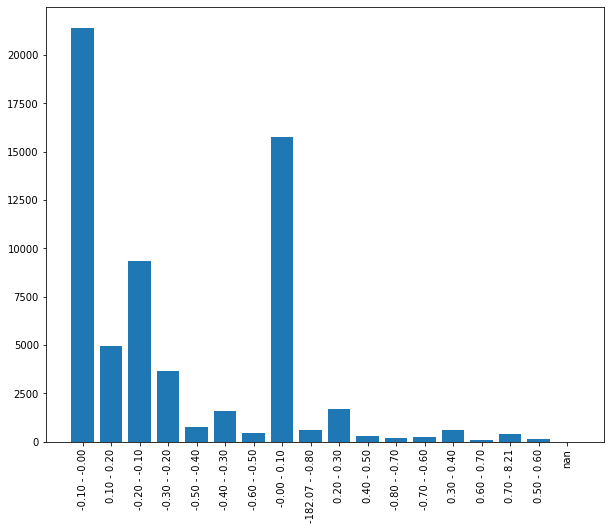

In [20]:
# bin y
bins = np.concatenate([[X_ys['revt']['y'].min()], np.arange(-.8, .8, .1), [X_ys['revt']['y'].max()]])
X_ys['revt']['y_binned'] = pd.cut(X_ys['revt']['y'], bins=bins,
       labels=[f"{a:.2f} - {b:.2f}" for a, b in zip(bins[:-1], bins[1:])],
       right=True)
f = plt.figure(figsize=(10,8))
plt.bar([str(a) for a in Counter(X_ys['revt']['y_binned']).keys()], 
        height=list(Counter(X_ys['revt']['y_binned']).values()))
plt.xticks(rotation=90)
plt.show()

## 1.2 imputating missing values & balancing

In [21]:
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE

def encodeNonNumeric(X: pd.DataFrame, y: pd.Series, encode_y=True):
    """encode non-numeric columns"""
    les = {}
    numeric_cols = X.describe().columns
    for colname in X.columns:
        if colname not in numeric_cols:
            print(f"encoding {colname}")
            les[colname] = LabelEncoder()
            X[colname] = les[colname].fit_transform(X[colname])
    if encode_y:
        les['y'] = LabelEncoder()
        print("encoding y")
        y = pd.Series(les['y'].fit_transform(y.values), 
                        index=y.index, name='target')
    return X, y, les

def impRebalance(X: pd.DataFrame, y: pd.Series, imputate_only=False, missing_tolerance=0.5, k=3, random_state=1):
    """returns the imputated, rebalanced dataset
    Imputates and relances the dataset, and returns X, y and the new column
    labels

    Parameters
    --------
    X: must be pd.Dataframe
    y: must be pd.Series
    """
    # imputation with simple imputator
    X_col_filter = (X.isna().sum(axis='index') / len(X)) > missing_tolerance
    X = X.loc[:, ~X_col_filter]
    imp = SimpleImputer(strategy="median")
    X_imp = pd.DataFrame(imp.fit_transform(X), index=X.index, columns=X.columns)

    if imputate_only:
        return X_imp, y, X_col_filter

    # Check for classes with few samples for SMOTE
    y.name = 'target'
    few_samples = {key: val for key, val in Counter(y).items() if val < k}
    drop_ind = y.loc[y.isin(list(few_samples.keys()))].index
    X_imp, y = X_imp.drop(drop_ind, axis="index"), y.drop(drop_ind, axis="index")

    # balancing dataset 
    smote = SMOTE(random_state=random_state, n_jobs=-1, k_neighbors=k)
    X_smote, y_smote = smote.fit_resample(X_imp, y)
    # X_smote = pd.DataFrame(X_smote, columns=X.columns)
    # y_smote.columns = ['target']

    return X_smote, y_smote, X_col_filter

# **2. Train classification model**

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [23]:
X, y, les = encodeNonNumeric(X_ys['revt']['X'], X_ys['revt']['y_binned'])
X_smote, y_smote, X_col_filter = impRebalance(X, y)
del X, y

encoding act_bins
encoding at_bins
encoding ebitda_bins
encoding seq_bins
encoding revt_bins
encoding mkvalt_bins
encoding y


## 2.0 Train test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3)

## 2.1 Decision Tree

In [ ]:
# downsample for HPO and CV
sample_size = int(10e4)
X_train_res = X_train.sample(sample_size)
y_train_res = y_train[X_train_res.index]

In [ ]:
# grid search for HPO
from sklearn.model_selection import GridSearchCV
parameters = {'criterion':('gini', 'entropy'), 
              'max_depth': list(range(1, 10))}
dtc = DecisionTreeClassifier(random_state=10)
clf = GridSearchCV(dtc, parameters)


clf.fit(X_train_res, y_train_res)

# print searched best HP
print(clf.cv_results_)

In [ ]:
clf.cv_results_

{'mean_fit_time': array([ 10.00821147,  19.19895406,  21.95625019,  29.23359957,
         35.3075388 ,  41.12980742,  63.10938268,  62.48204012,
         61.80362806,  42.8801928 ,  85.6067903 , 128.79622059,
        173.22371531, 221.18903308, 265.85680017, 310.5721354 ,
        353.95810266, 397.37131596]),
 'mean_score_time': array([0.03680601, 0.04160032, 0.03095846, 0.04892545, 0.03546858,
        0.03555799, 0.09691548, 0.03837576, 0.03724279, 0.03505044,
        0.03714385, 0.03659406, 0.04019856, 0.04232917, 0.04309645,
        0.04234047, 0.04074702, 0.04499388]),
 'mean_test_score': array([0.0487 , 0.04917, 0.04907, 0.04926, 0.0493 , 0.04923, 0.04875,
        0.04884, 0.0492 , 0.04873, 0.04873, 0.04864, 0.04891, 0.04851,
        0.04858, 0.04851, 0.04849, 0.04823]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'gini',
                    'gini', 'gini', 'entropy', 'entropy', 'entropy',
                    'entropy', 'entropy', 'entrop

In [27]:
# train a simple decision tree first

# dtc_res = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=1)
# dtc_res.fit(X_train_res, y_train_res)

dtc = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=10)
dtc.fit(X_train, y_train)

# pipe_dtc = make_pipeline(dtc, verbose=True)
# pipe_dtc.fit(X_train, y_train)

y_hat = dtc.predict(X_test)
# y_hat = dtc_res.predict(X_test)

print(accuracy_score(y_pred=y_hat, y_true=y_test))

0.4523833499638401


In [ ]:
# learning curve for model tuninig
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=dtc_res, X=X_train, y=y_train, 
                                         train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

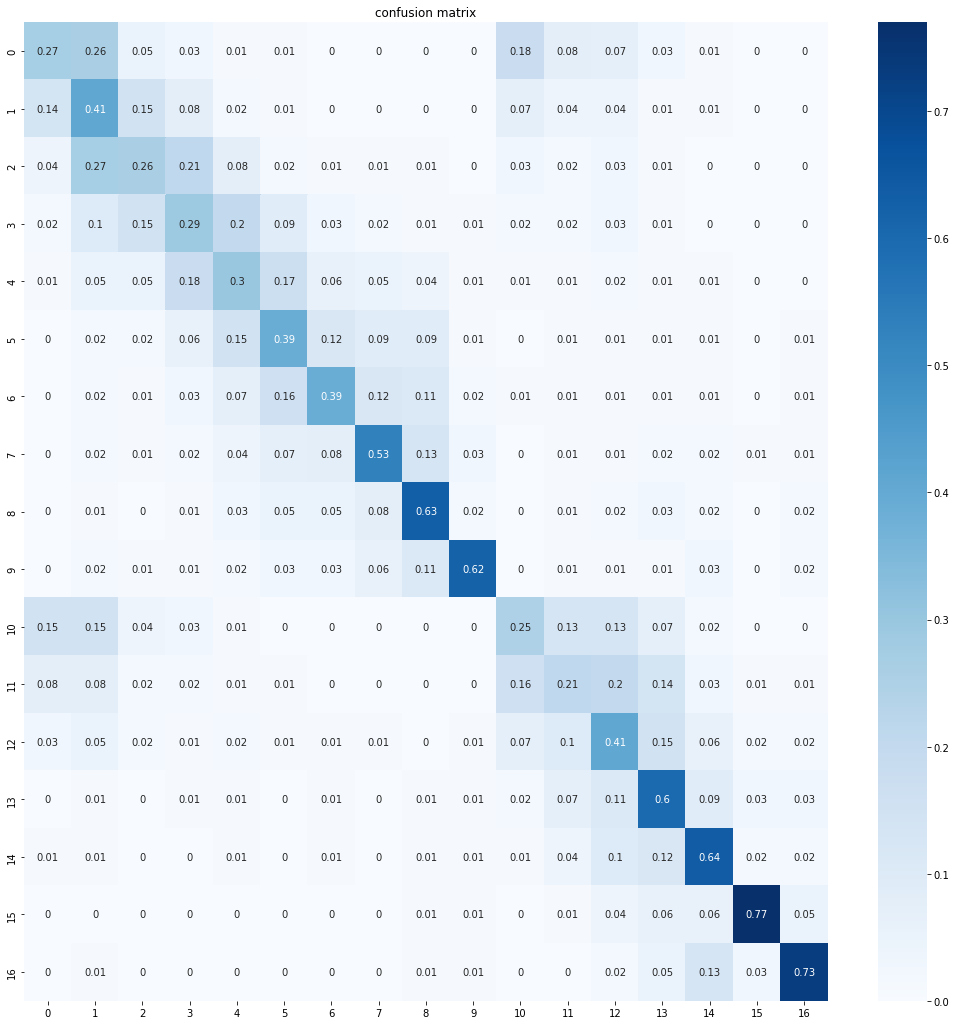

In [28]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_hat, normalize='true')
f, ax = plt.subplots(1, figsize=(18, 18))
ax = sns.heatmap(conf_mat.round(2), cmap='Blues', annot=True)
plt.title("confusion matrix")
plt.show()

In [29]:
feature_importance = pd.Series(dtc.feature_importances_, index=X_smote.columns)

In [30]:
feature_importance.sort_values(ascending=False).head(20)

revt_3yr_cagr                       0.205622
revt_1yr_cagr                       0.144923
ebit_margin_vs_gind_t1yr_avg        0.076351
revt_bins                           0.030894
ni_margin_t10yr_std                 0.021464
sic                                 0.017026
market_share_t10yr_chg              0.012443
gind                                0.011572
roe_vs_gind_std_t1yr_chg            0.007671
years_from_500_to_1000              0.006927
ocf_margin_vs_gind_std_t10yr_chg    0.006865
gp_margin_vs_gind_std_t1yr_std      0.006848
market_share_t1yr_chg               0.006699
ocf_margin_vs_gind_std_t5yr_std     0.006525
ebit_margin_vs_gind_t20yr_avg       0.006082
tax_rate_vs_gind_std_t20yr_chg      0.005929
ebit_margin_vs_gind_t10yr_std       0.005788
ebit_margin_t5yr_avg                0.005596
seq_20yr_cagr                       0.005515
ni_margin_t10yr_avg                 0.005490
dtype: float64

## 2.2 Let's try Naive Bayes

## 2.3 SVM with PCA

In [ ]:
# PCA
pca = PCA(n_components=3)
X_sc = pd.DataFrame(sc.fit_transform(X_smote), index=X_smote.index, columns=X_smote.columns)
X_pca = pd.DataFrame(pca.fit_transform(X_sc, y), 
                     columns=[f'pc{i}' for i in range(1, 4)],
                     index=X_sc.index)
print(pca.explained_variance_ratio_)

[0.21140726 0.06343321 0.05292462]


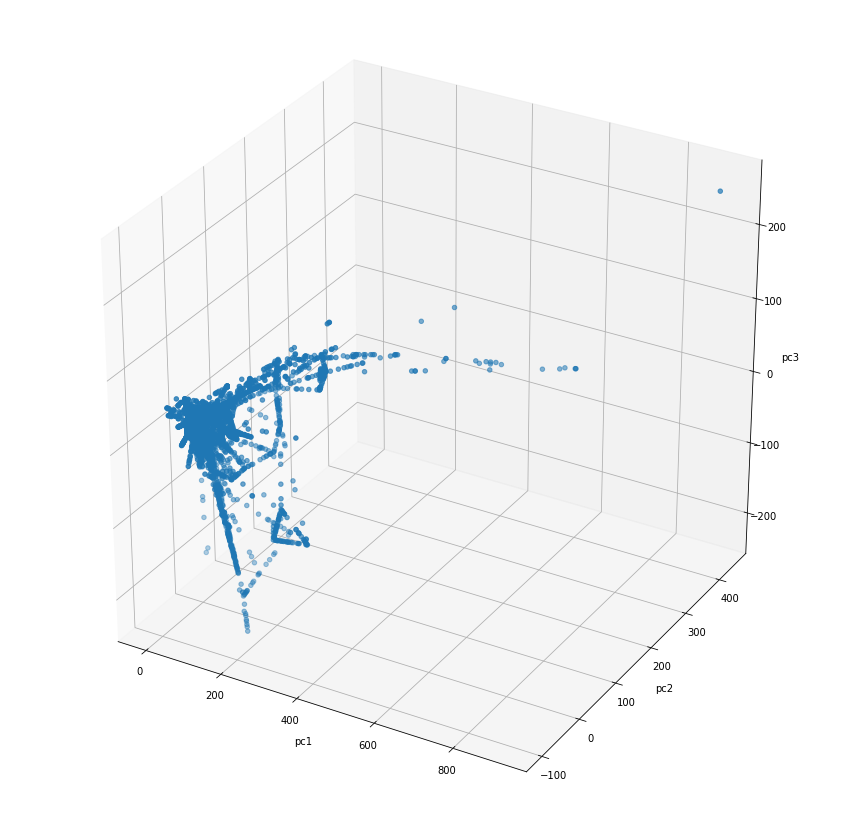

In [ ]:
# Visualize PCA results
# let's visualize the PCA-transformed data first
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

f = plt.figure(figsize=(15, 15))
ax = f.add_subplot(111, projection='3d')
ax.scatter(X_pca['pc1'], X_pca['pc2'], X_pca['pc3'], marker="o")

ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
ax.set(
    # xlim=(-10, 10), 
    # ylim=(0, 20), 
    # zlim=(-30, 30)
    )
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

pipe_svm = make_pipeline(sc, PCA(n_components=5), SVC(kernel='linear', C=1))
pipe_svm.fit(X_train, y_train)
y_hat = pipe_svm.predict(X_test)
print(f"accuracy - {accuracy_score(y_pred=y_hat, y_true=y_test)}")

In [ ]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_hat, normalize='true')
f, ax = plt.subplots(1, figsize=(18, 18))
ax = sns.heatmap(conf_mat.round(2), cmap='Blues', annot=True)
plt.title("confusion matrix")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

## 2.4 Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50, max_depth=5)
pipe_rfc = make_pipeline(rfc)
pipe_rfc.fit(X_train, y_train)
y_hat = pipe_rfc.predict(X_test)
print(f"accuracy - {accuracy_score(y_pred=y_hat, y_true=y_test)}")

accuracy - 0.22465831174418924


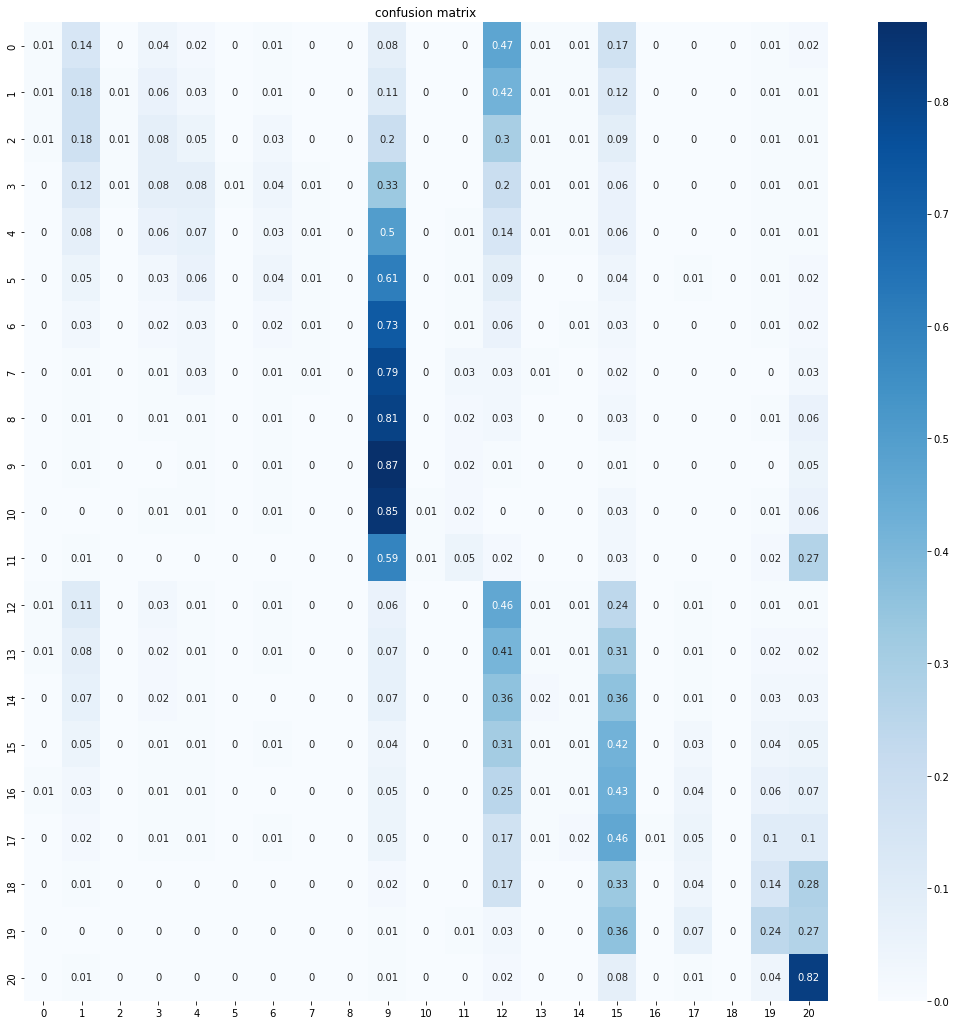

In [ ]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_hat, normalize='true')
f, ax = plt.subplots(1, figsize=(18, 18))
ax = sns.heatmap(conf_mat.round(2), cmap='Blues', annot=True)
plt.title("confusion matrix")
plt.show()

In [ ]:
import pickle
pickle.dump(pipe_rfc, open("/content/drive/MyDrive/stockClassification/sector_specific/rfclf", "wb"))

In [ ]:
# grid search for HPO
from sklearn.model_selection import GridSearchCV

## 2.5 Adaboost with decision tree as base estimator

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100, base_estimator=dtc)
pipe_adb= make_pipeline(adb)
pipe_adb.fit(X_train, y_train)
y_hat = pipe_rfc.predict(X_test)
print(f"accuracy - {accuracy_score(y_pred=y_hat, y_true=y_test)}")

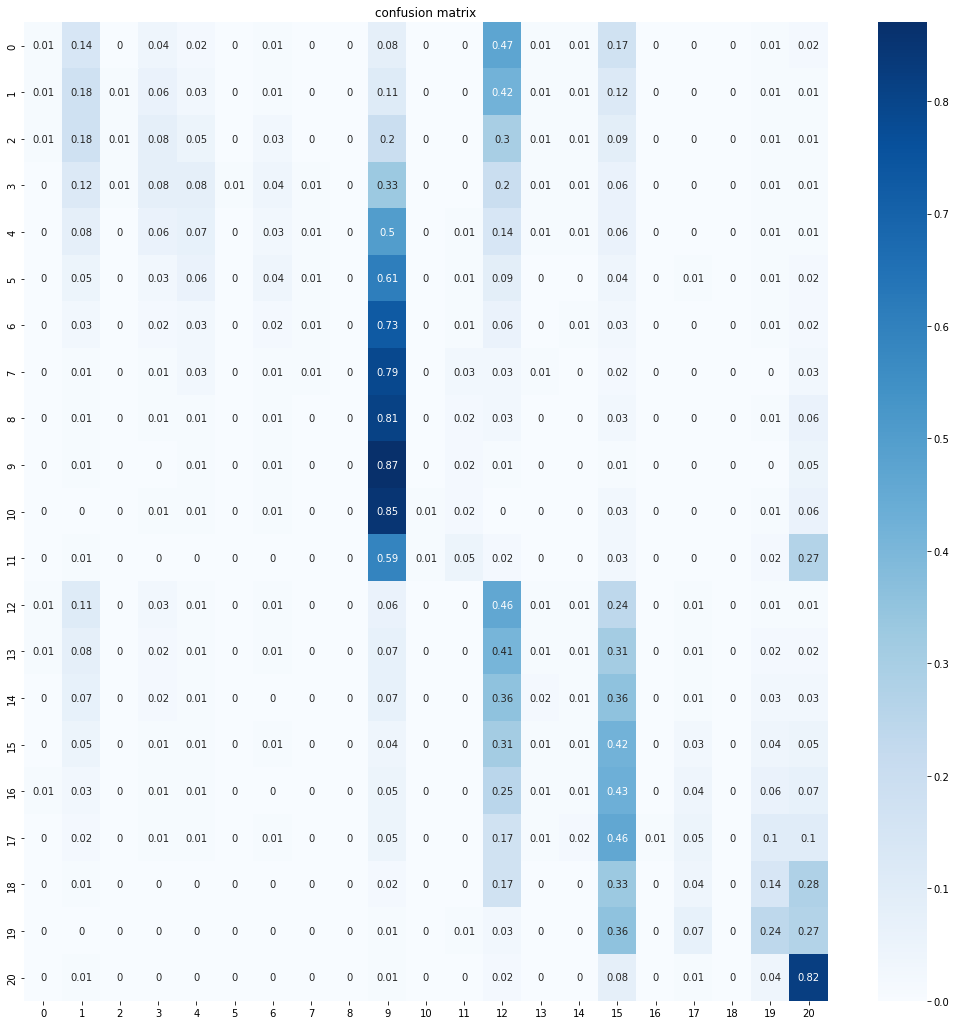

In [ ]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_hat, normalize='true')
f, ax = plt.subplots(1, figsize=(18, 18))
ax = sns.heatmap(conf_mat.round(2), cmap='Blues', annot=True)
plt.title("confusion matrix")
plt.show()

In [ ]:
import pickle
pickle.dump(pipe_rfc, open("/content/drive/MyDrive/stockClassification/sector_specific/adboostclf", "wb"))

# **3. Train a regressor**

In [32]:
X, y_numeric, les_numeric = encodeNonNumeric(X_ys['revt']['X'], X_ys['revt']['y'], encode_y=False)
X_imp, y_imp_numeric, X_col_filter = impRebalance(X, y_numeric, imputate_only=True)
# del X, y_numeric
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp_numeric, test_size=0.3)

## 3.1 SGDRegressor


In [33]:
X_train

,,years_from_10_to_50,years_from_50_to_100,years_from_100_to_500,years_from_500_to_1000,years_since_y0,act_1yr_cagr,act_3yr_cagr,act_5yr_cagr,act_10yr_cagr,act_20yr_cagr,at_1yr_cagr,at_3yr_cagr,at_5yr_cagr,at_10yr_cagr,at_20yr_cagr,ebitda_1yr_cagr,ebitda_3yr_cagr,ebitda_5yr_cagr,ebitda_10yr_cagr,ebitda_20yr_cagr,seq_1yr_cagr,seq_3yr_cagr,seq_5yr_cagr,seq_10yr_cagr,seq_20yr_cagr,revt_1yr_cagr,revt_3yr_cagr,revt_5yr_cagr,revt_10yr_cagr,revt_20yr_cagr,ebit_margin_t1yr_avg,ebit_margin_t1yr_std,ebit_margin_t1yr_chg,ebit_margin_t3yr_avg,ebit_margin_t3yr_std,ebit_margin_t3yr_chg,ebit_margin_t5yr_avg,ebit_margin_t5yr_std,ebit_margin_t5yr_chg,ebit_margin_t10yr_avg,...,ebitda_bins,seq_bins,revt_bins,mkvalt_bins,ocf_margin_t1yr_avg,ocf_margin_t1yr_std,ocf_margin_t1yr_chg,ocf_margin_vs_gind_t1yr_avg,ocf_margin_vs_gind_t1yr_std,ocf_margin_vs_gind_t1yr_chg,ocf_margin_vs_gind_std_t1yr_avg,ocf_margin_vs_gind_std_t1yr_std,ocf_margin_vs_gind_std_t1yr_chg,ocf_margin_t3yr_avg,ocf_margin_t3yr_std,ocf_margin_t3yr_chg,ocf_margin_vs_gind_t3yr_avg,ocf_margin_vs_gind_t3yr_std,ocf_margin_vs_gind_t3yr_chg,ocf_margin_vs_gind_std_t3yr_avg,ocf_margin_vs_gind_std_t3yr_std,ocf_margin_vs_gind_std_t3yr_chg,ocf_margin_t5yr_avg,ocf_margin_t5yr_std,ocf_margin_t5yr_chg,ocf_margin_vs_gind_t5yr_avg,ocf_margin_vs_gind_t5yr_std,ocf_margin_vs_gind_t5yr_chg,ocf_margin_vs_gind_std_t5yr_avg,ocf_margin_vs_gind_std_t5yr_std,ocf_margin_vs_gind_std_t5yr_chg,ocf_margin_t10yr_avg,ocf_margin_t10yr_std,ocf_margin_t10yr_chg,ocf_margin_vs_gind_t10yr_avg,ocf_margin_vs_gind_t10yr_std,ocf_margin_vs_gind_t10yr_chg,ocf_margin_vs_gind_std_t10yr_avg,ocf_margin_vs_gind_std_t10yr_std,ocf_margin_vs_gind_std_t10yr_chg
tic,year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SO,2012,3.754112,3.015394,15.378276,5.720993,61.0,-0.017538,0.016141,0.054230,0.075822,0.050606,0.065500,0.066579,0.066402,0.071014,0.051605,0.047579,0.078069,0.063921,0.055575,0.034253,0.038532,0.066840,0.075536,0.079618,0.041499,-0.063431,0.016537,0.014969,0.045983,0.036507,0.254176,0.020583,0.029109,0.236643,0.023500,0.048315,0.227986,0.022923,0.052096,0.231482,...,9.0,3.0,1.0,10.0,0.315250,0.026962,-0.038131,0.081892,0.038562,-0.054535,0.746453,0.370791,-0.524378,0.266600,0.058942,0.088918,0.039953,0.053639,0.063990,0.365697,0.492613,0.572188,0.247655,0.054750,0.075055,0.041579,0.041726,0.005201,0.393179,0.384334,0.008772,0.239965,0.047304,0.027818,0.047985,0.036397,-0.024961,0.408611,0.291278,-0.193919
MLI,1982,3.754112,3.015394,13.262384,9.621928,17.0,-0.237486,-0.123284,0.232612,0.158735,0.090963,-0.121238,-0.017426,0.253682,0.178119,0.094926,-1.738186,0.079285,0.080585,0.090434,0.088962,-0.507383,-0.247284,-0.109032,-0.008343,0.087137,-0.240234,0.090281,0.108290,0.086790,0.093045,-0.036757,0.091336,-0.129169,0.007881,0.077329,-0.182382,0.032068,0.072917,-0.153282,0.056099,...,11.0,2.0,4.0,12.0,0.105607,0.023449,-0.000146,0.021297,0.024265,-0.000493,0.005364,0.027677,-0.000051,0.105331,0.034554,0.001384,0.021828,0.034988,-0.000884,0.007140,0.054080,-0.000487,0.105188,0.040044,0.002905,0.022390,0.040501,-0.002097,0.008117,0.066323,-0.000941,0.106383,0.049996,0.008896,0.024118,0.049919,-0.002420,0.009362,0.086549,-0.001547
MNIQQ,2003,3.754112,3.015394,7.428248,3.845989,16.0,-0.240704,-0.071637,-0.012350,0.052304,0.090963,-0.053191,-0.046852,-0.035496,0.135737,0.094926,-0.003436,-0.024109,0.028381,0.122041,0.088962,0.150084,0.082421,0.085457,0.122315,0.087137,0.016169,-0.012631,0.025645,0.093653,0.093045,0.227194,0.001073,-0.001518,0.205019,0.031233,0.021703,0.202220,0.025365,0.039724,0.176629,...,8.0,5.0,3.0,9.0,0.160632,0.005663,0.008008,0.010640,0.004457,-0.006303,0.000243,0.000025,-0.000035,0.165833,0.011497,0.004921,0.027308,0.021557,-0.025021,0.008716,0.010420,-0.012572,0.158765,0.014582,0.025806,0.021013,0.020780,0.011093,0.001248,0.018176,0.032037,0.165880,0.023651,-0.037348,0.024420,0.026632,-0.061453,0.110422,0.269723,-0.837268
5672A,2003,3.754112,3.015394,2.566431,2.280038,16.

In [34]:
y_train

tic    year
SO     2012    0.070370
MLI    1982    0.040893
MNIQQ  2003    0.090763
5672A  2003    0.124933
ORLY   2002   -0.103894
                 ...   
WIT    2010   -0.162736
TRR    2006   -0.180711
JEF    2007    0.413820
MIDD   2003    0.089727
ONB    1998   -0.019107
Length: 43555, dtype: float64

In [ ]:
# downsample for HPO and CV
sample_size = int(2*10e3)
X_train_res = X_train.sample(sample_size)
y_train_res = y_train[X_train_res.index]

In [ ]:
# grid search for HPO
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01],
              'l1_ratio': [0.1, 0.15, 0.2],
              'eta0': [0.001, 0.01, 0.1], 
              'epsilon': [0.05, 0.1, 0.15],}
sgdr = SGDRegressor(loss='squared_error', penalty='l2',  
                    fit_intercept=True, max_iter=1000, 
                    tol=0.001, shuffle=True, verbose=True, 
                    random_state=1, learning_rate='invscaling', 
                    power_t=0.25, early_stopping=False, validation_fraction=0.1, 
                    n_iter_no_change=5, warm_start=False, average=False)
clf_sgd = GridSearchCV(sgdr, parameters)

clf_sgd.fit(X_train_res, y_train_res)

# print searched best HP
sorted(clf_sgd.cv_results_)

In [ ]:
[(a, b) for a, b in zip(clf_sgd.cv_results_['params'], clf_sgd.cv_results_['rank_test_score'])]

[({'alpha': 1e-05, 'epsilon': 0.05, 'eta0': 0.001, 'l1_ratio': 0.1}, 1),
 ({'alpha': 1e-05, 'epsilon': 0.05, 'eta0': 0.001, 'l1_ratio': 0.15}, 1),
 ({'alpha': 1e-05, 'epsilon': 0.05, 'eta0': 0.001, 'l1_ratio': 0.2}, 1),
 ({'alpha': 1e-05, 'epsilon': 0.05, 'eta0': 0.01, 'l1_ratio': 0.1}, 64),
 ({'alpha': 1e-05, 'epsilon': 0.05, 'eta0': 0.01, 'l1_ratio': 0.15}, 64),
 ({'alpha': 1e-05, 'epsilon': 0.05, 'eta0': 0.01, 'l1_ratio': 0.2}, 64),
 ({'alpha': 1e-05, 'epsilon': 0.05, 'eta0': 0.1, 'l1_ratio': 0.1}, 100),
 ({'alpha': 1e-05, 'epsilon': 0.05, 'eta0': 0.1, 'l1_ratio': 0.15}, 100),
 ({'alpha': 1e-05, 'epsilon': 0.05, 'eta0': 0.1, 'l1_ratio': 0.2}, 100),
 ({'alpha': 1e-05, 'epsilon': 0.1, 'eta0': 0.001, 'l1_ratio': 0.1}, 1),
 ({'alpha': 1e-05, 'epsilon': 0.1, 'eta0': 0.001, 'l1_ratio': 0.15}, 1),
 ({'alpha': 1e-05, 'epsilon': 0.1, 'eta0': 0.001, 'l1_ratio': 0.2}, 1),
 ({'alpha': 1e-05, 'epsilon': 0.1, 'eta0': 0.01, 'l1_ratio': 0.1}, 64),
 ({'alpha': 1e-05, 'epsilon': 0.1, 'eta0': 0.01, 'l

In [ ]:
clf_sgd.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'param_epsilon', 'param_eta0', 'param_l1_ratio', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [51]:
from sklearn.linear_model import SGDRegressor
sc1 = StandardScaler()
sc2 = StandardScaler()
sgdr = SGDRegressor(loss='squared_error', penalty='l2', fit_intercept=True, max_iter=1000, 
                    tol=0.001, shuffle=True, verbose=True, 
                    random_state=1, learning_rate='invscaling',  
                    power_t=0.25, early_stopping=False, validation_fraction=0.1, 
                    n_iter_no_change=5, warm_start=False, average=False,
                    alpha=0.0001, epsilon=0.1, eta0=0.001, l1_ratio=0.1)
pipe_sgdr = make_pipeline(sc1, PCA(n_components=10), sc2, sgdr)
pipe_sgdr.fit(X_train, y_train)

import pickle
pickle.dump(pipe_sgdr, open("/content/drive/MyDrive/stockClassification/sector_specific/sgdRegressor", "wb"))

-- Epoch 1
Norm: 0.20, NNZs: 10, Bias: -0.053175, T: 43555, Avg. loss: 0.303827
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 10, Bias: -0.053486, T: 87110, Avg. loss: 0.296935
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 0.20, NNZs: 10, Bias: -0.056864, T: 130665, Avg. loss: 0.293743
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 10, Bias: -0.055087, T: 174220, Avg. loss: 0.297859
Total training time: 0.18 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 10, Bias: -0.059510, T: 217775, Avg. loss: 0.295086
Total training time: 0.21 seconds.
-- Epoch 6
Norm: 0.17, NNZs: 10, Bias: -0.051732, T: 261330, Avg. loss: 0.294745
Total training time: 0.24 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 10, Bias: -0.054018, T: 304885, Avg. loss: 0.294877
Total training time: 0.26 seconds.
-- Epoch 8
Norm: 0.16, NNZs: 10, Bias: -0.052737, T: 348440, Avg. loss: 0.295025
Total training time: 0.27 seconds.
Convergence after 8 epochs took 0.27 seconds


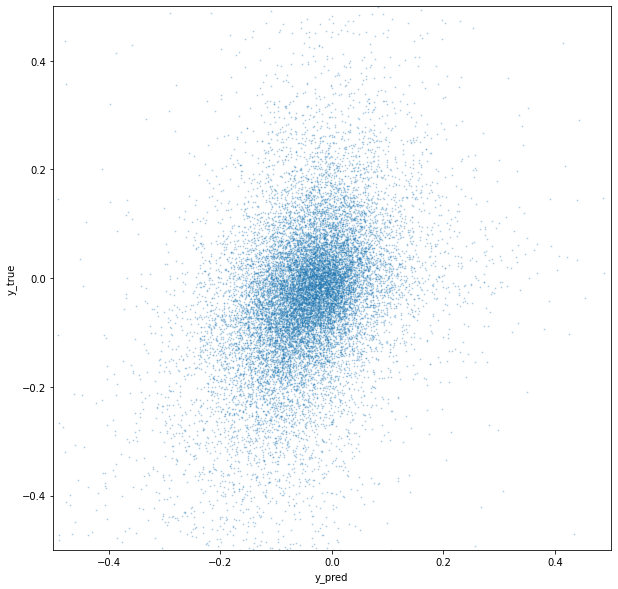

In [95]:
y_hat = pipe_sgdr.predict(X_test)
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set(xlabel='y_pred', ylabel='y_true')
ax.scatter(y_hat, y_test.values, s=1, alpha=0.3)

plt.ylim(-0.5, 0.5)
plt.xlim(-0.5, 0.5)
plt.show()

## 3.2 ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
eln = ElasticNet(alpha=0.01, l1_ratio=0.5)
sc1 = StandardScaler()
sc2 = StandardScaler()

pipe_eln = make_pipeline(sc1, PCA(n_components=5), sc2, eln, verbose=True)
pipe_eln.fit(X_train, y_train)

# import pickle
# pickle.dump(pipe_sgdr, open("/content/drive/MyDrive/stockClassification/sector_specific/sgdRegressor", "wb"))

[Pipeline] .. (step 1 of 4) Processing standardscaler-1, total=   0.3s
[Pipeline] ............... (step 2 of 4) Processing pca, total=   2.3s
[Pipeline] .. (step 3 of 4) Processing standardscaler-2, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing elasticnet, total=   0.0s


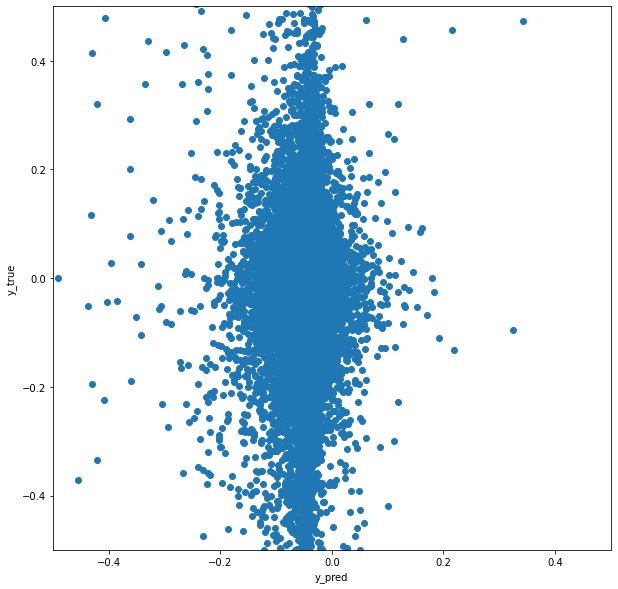

In [ ]:
y_hat = pipe_eln.predict(X_test)
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set(xlabel='y_pred', ylabel='y_true')
ax = plt.scatter(y_hat, y_test.values, s=1, alpha=0.3)

plt.ylim(-0.5, 0.5)
plt.xlim(-0.5, 0.5)
plt.show()

## 3.3 Decision Tree Regressor

In [91]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5, random_state=1)
sc1 = StandardScaler()
# sc2 = StandardScaler()

pipe_dtr = make_pipeline(
    sc1, 
    # PCA(n_components=5), sc2, 
    dtr, verbose=True)
pipe_dtr.fit(X_train, y_train)

import pickle
pickle.dump(pipe_dtr, open("/content/drive/MyDrive/stockClassification/sector_specific/DecisionTreeRegressor", "wb"))

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.3s
[Pipeline]  (step 2 of 2) Processing decisiontreeregressor, total=  12.7s


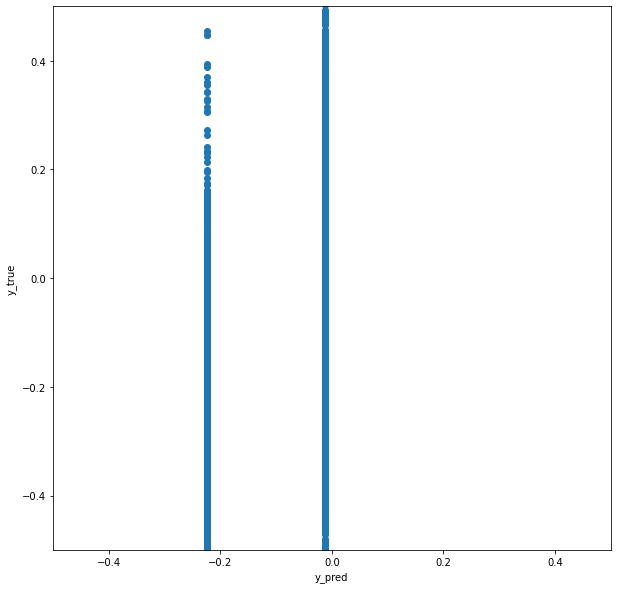

In [92]:
y_hat = pipe_dtr.predict(X_test)
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set(xlabel='y_pred', ylabel='y_true')
ax = plt.scatter(y_hat, y_test.values)

plt.ylim(-0.5, 0.5)
plt.xlim(-0.5, 0.5)
plt.show()

## 3.4 AdaBoostRegressor

In [93]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5, random_state=1)
abr = AdaBoostRegressor(base_estimator=dtr, learning_rate=0.5)
# sc1 = StandardScaler()
# sc2 = StandardScaler()

pipe_abr = make_pipeline(
    # sc1, PCA(n_components=5), sc2, 
    abr, verbose=True)
pipe_abr.fit(X_train, y_train)

import pickle
pickle.dump(pipe_abr, open("/content/drive/MyDrive/stockClassification/sector_specific/AdaBoostRegressor", "wb"))

[Pipeline] . (step 1 of 1) Processing adaboostregressor, total= 7.3min


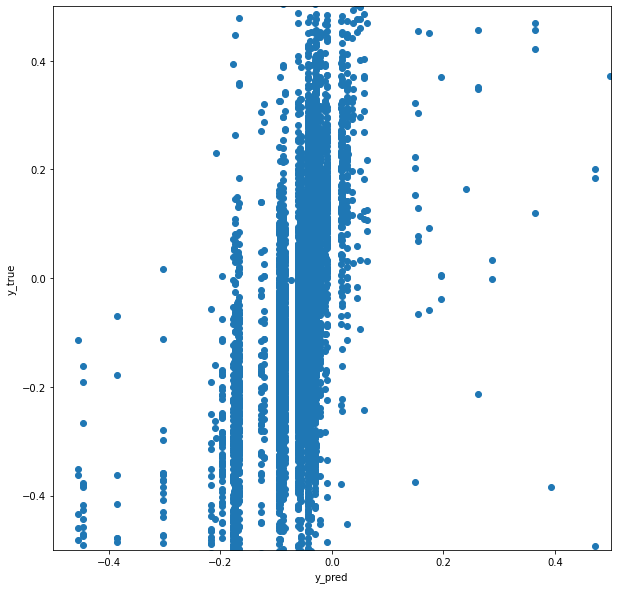

In [94]:
y_hat = pipe_abr.predict(X_test)
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set(xlabel='y_pred', ylabel='y_true')
ax = plt.scatter(y_hat, y_test.values)

plt.ylim(-0.5, 0.5)
plt.xlim(-0.5, 0.5)
plt.show()

Hmmm... That's not great... In fact much worse than simple SGD regressor

### 3.4.1 What about using SGD as the base estimator? It would seem strange but let's try that anyway

-- Epoch 1
Norm: 0.21, NNZs: 10, Bias: -0.062418, T: 43555, Avg. loss: 0.465496
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 10, Bias: -0.059831, T: 87110, Avg. loss: 0.458626
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.24, NNZs: 10, Bias: -0.063722, T: 130665, Avg. loss: 0.457741
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 10, Bias: -0.061502, T: 174220, Avg. loss: 0.457445
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.20, NNZs: 10, Bias: -0.058272, T: 217775, Avg. loss: 0.457768
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.21, NNZs: 10, Bias: -0.062806, T: 261330, Avg. loss: 0.456586
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 0.23, NNZs: 10, Bias: -0.059199, T: 304885, Avg. loss: 0.456153
Total training time: 0.07 seconds.
Convergence after 7 epochs took 0.07 seconds
-- Epoch 1
Norm: 0.82, NNZs: 10, Bias: -0.118458, T: 43555, Avg. loss: 2.733441
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.81, NNZs: 1

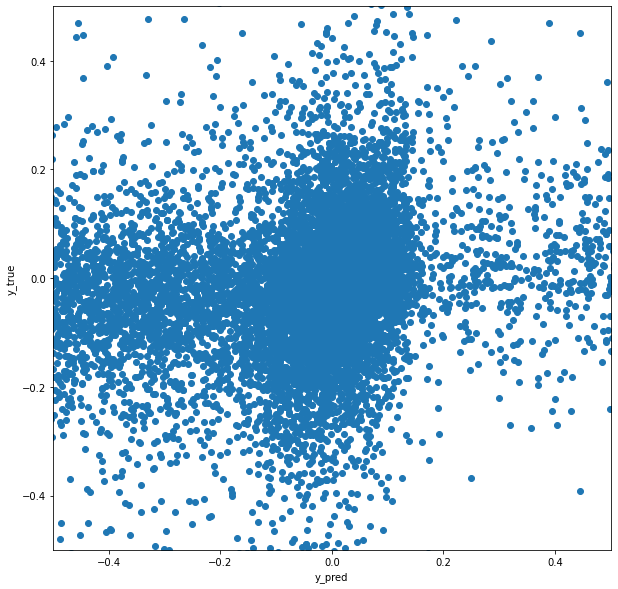

In [100]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
sc1 = StandardScaler()
sc2 = StandardScaler()
sgdr = SGDRegressor(loss='squared_error', penalty='l2', fit_intercept=True, max_iter=1000, 
                    tol=0.001, shuffle=True, verbose=True, 
                    random_state=1, learning_rate='invscaling',  
                    power_t=0.25, early_stopping=False, validation_fraction=0.1, 
                    n_iter_no_change=5, warm_start=False, average=False,
                    alpha=0.0001, epsilon=0.1, eta0=0.001, l1_ratio=0.1)

abr = AdaBoostRegressor(base_estimator=sgdr, learning_rate=0.5)
pipe_abrsgd = make_pipeline(sc1, PCA(n_components=10), sc2, abr)
pipe_abrsgd.fit(X_train, y_train)

y_hat = pipe_abrsgd.predict(X_test)
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set(xlabel='y_pred', ylabel='y_true')
ax = plt.scatter(y_hat, y_test.values)

plt.ylim(-0.5, 0.5)
plt.xlim(-0.5, 0.5)
plt.show()

## 3.5 Gradient Boosting

In [98]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
sc1 = StandardScaler()
gbr = GradientBoostingRegressor(loss='squared_error', learning_rate=0.05, 
                               n_estimators=100, subsample=1.0, criterion='friedman_mse',  
                               min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                               random_state=1, max_features=None, alpha=0.9, verbose=True, 
                               max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                               n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
pipe_gbr = make_pipeline(sc1, gbr)
pipe_gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.5638           21.88m
         2           0.5133           21.59m
         3           0.4673           21.42m
         4           0.4259           21.27m
         5           0.3886           21.21m
         6           0.3546           21.10m
         7           0.3240           20.95m
         8           0.2962           20.79m
         9           0.2713           20.62m
        10           0.2485           20.41m
        20           0.1115           18.37m
        30           0.0598           15.90m
        40           0.0397           13.50m
        50           0.0313           11.18m
        60           0.0273            8.90m
        70           0.0249            6.64m
        80           0.0232            4.41m
        90           0.0218            2.20m
       100           0.0203            0.00s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=5,
                                           random_state=1, verbose=True))])

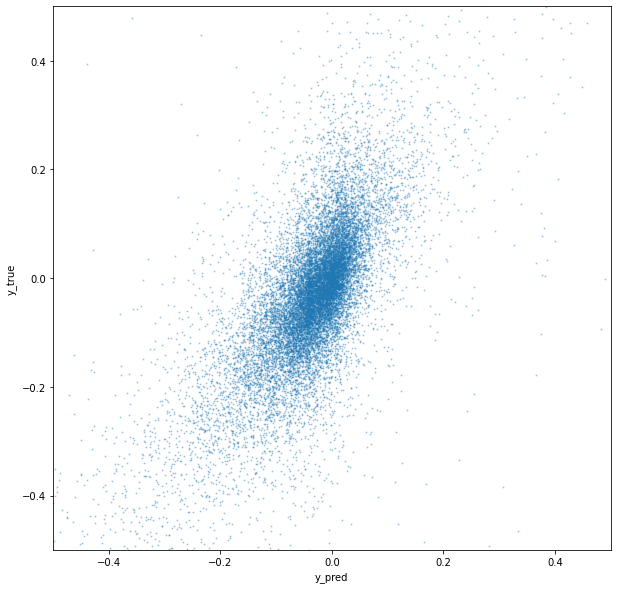

In [99]:
y_hat = pipe_gbr.predict(X_test)
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set(xlabel='y_pred', ylabel='y_true')
ax = plt.scatter(y_hat, y_test.values, alpha=0.3, s=1)

plt.ylim(-0.5, 0.5)
plt.xlim(-0.5, 0.5)
plt.show()

Amazing results!

In [102]:
import pickle
pickle.dump(pipe_gbr, open("/content/drive/MyDrive/stockClassification/sector_specific/GBRegressor", "wb"))

# **4. Let's do some predictions with our best models so far**

In [127]:
# let's test the model on 2015 data first
X_y_15 = getDataSet(year=2015, return_X_y=False)
X_y_15 = X_y_15.loc[~X_y_15.revt_bins.isin(filter_out), :]
X_15, y_15 = X_y_15.drop("target", axis='columns'), X_y_15.target
X_15 = X_15.loc[:, ~X_col_filter]
X_15, y_15 = X_15.loc[~y_15.isna(), :], y_15[~y_15.isna()]

In [131]:
X_y_15.revt_bins.unique()

['3*10e4<x<=1*10e4', '10*10e3<x<=3*10e4', '1*10e4<x<=3*10e4', '1*10e2<x<=3*10e2', '3*10e4<x<=1*10e5', '3*10e2<x<=10*10e3', '1*10e5<x<=3*10e6', NaN, '3*10e6<x<=10*10e6']
Categories (8, object): ['1*10e2<x<=3*10e2' < '3*10e2<x<=10*10e3' < '10*10e3<x<=3*10e4' <
                         '3*10e4<x<=1*10e4' < '1*10e4<x<=3*10e4' < '3*10e4<x<=1*10e5' <
                         '1*10e5<x<=3*10e6' < '3*10e6<x<=10*10e6']

In [132]:
# encode X_15
for lab, le in les.items():
    if lab != 'y':
        print(lab)
        X_15.loc[:, lab] = le.transform(X_15.loc[:, lab])

act_bins
at_bins
ebitda_bins
seq_bins
revt_bins
mkvalt_bins


In [143]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="median")
X_15 = X_15.replace(float("inf"), np.nan).replace(float("-inf"), np.nan)
X_15_imp = pd.DataFrame(imp.fit_transform(X_15), index=X_15.index, columns=X_15.columns)

In [146]:
X_15_imp.columns

Index(['years_from_10_to_50', 'years_from_50_to_100', 'years_from_100_to_500',
       'years_from_500_to_1000', 'years_since_y0', 'act_1yr_cagr',
       'act_3yr_cagr', 'act_5yr_cagr', 'act_10yr_cagr', 'act_20yr_cagr',
       ...
       'roe_vs_gind_std_t20yr_chg', 'ggroup', 'gind', 'sic', 'act_bins',
       'at_bins', 'ebitda_bins', 'seq_bins', 'revt_bins', 'mkvalt_bins'],
      dtype='object', length=453)

In [147]:
X.columns

Index(['years_from_10_to_50', 'years_from_50_to_100', 'years_from_100_to_500',
       'years_from_500_to_1000', 'years_since_y0', 'act_1yr_cagr',
       'act_3yr_cagr', 'act_5yr_cagr', 'act_10yr_cagr', 'act_20yr_cagr',
       ...
       'roe_vs_gind_std_t20yr_chg', 'ggroup', 'gind', 'sic', 'act_bins',
       'at_bins', 'ebitda_bins', 'seq_bins', 'revt_bins', 'mkvalt_bins'],
      dtype='object', length=453)

In [144]:
y_hat = pipe_gbr.predict(X_15_imp)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [140]:
y_15

tic    year
0141A  2015   -0.095237
0176A  2015    0.078583
0189A  2015    0.055834
0191A  2015   -0.159248
0218B  2015   -0.006748
                 ...   
ZUMZ   2015    0.042589
ZVO    2015   -0.067005
ZWS    2015   -0.057192
ZXAIY  2015   -0.065380
ZYNE   2015   -1.000000
Name: target, Length: 3165, dtype: float64

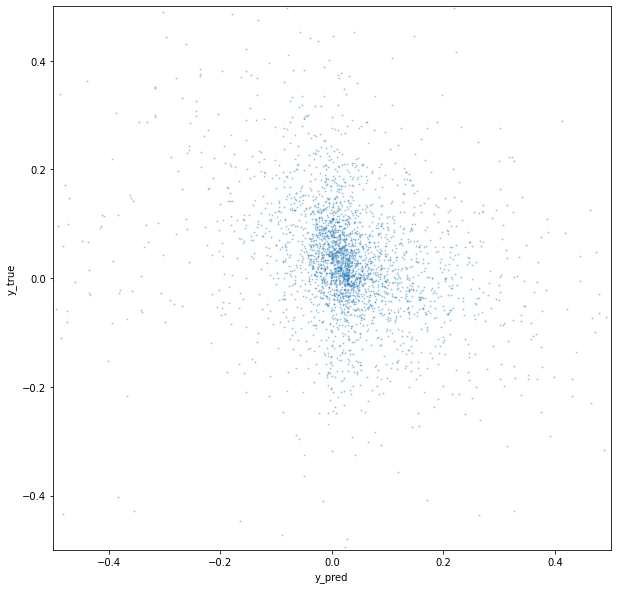

In [148]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set(xlabel='y_pred', ylabel='y_true')
ax = plt.scatter(y_hat, y_15.values, alpha=0.3, s=1)

plt.ylim(-0.5, 0.5)
plt.xlim(-0.5, 0.5)
plt.show()

# **5. Let's use the predictions from these models as inputs to our stock price prediction model**